# Custom Activation Fns

We just saw how wildly good LSTMs are at figuring out sequential patterns. Before going further down that rabbit hole, let's try actually modeling the domain with a custom activation function. This ought to be be much simpler.

In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset


# We'll need this later... get it out the way now
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

Let's set up our difficult test case like last time. Many peaks, no normalization.

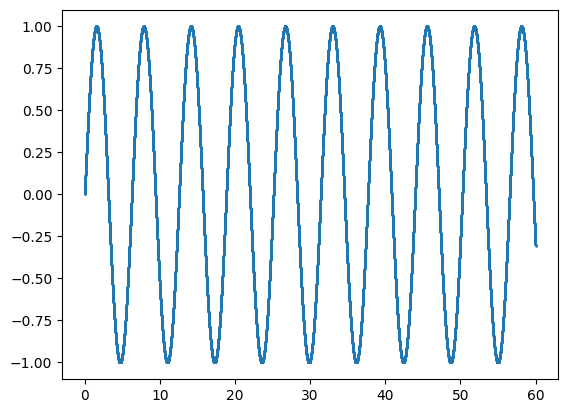

In [13]:
experiments = {}

class SineData:
    def __init__(self, m, c, n=100_000, dist_max=10, offset=0):
        self.m = m
        self.c = c
        self.n = n
        self.x_values = ((dist_max * np.random.rand(n)) - offset).astype(np.float32)
        self.y_values = m * np.sin(self.x_values) + c

        # Store normalization parameters
        self.x_min, self.x_max = self.x_values.min(), self.x_values.max()
        self.y_min, self.y_max = self.y_values.min(), self.y_values.max()

    def data(self):
        return np.column_stack((self.x_values, self.y_values))

    def normalized(self):
        x_normalized = (self.x_values - self.x_min) / (self.x_max - self.x_min)
        y_normalized = (self.y_values - self.y_min) / (self.y_max - self.y_min)
        return np.column_stack((x_normalized, y_normalized))

    def denormalize(self, normalized_data):
        x_normalized, y_normalized = normalized_data[:, 0], normalized_data[:, 1]
        x_denormalized = x_normalized * (self.x_max - self.x_min) + self.x_min
        y_denormalized = y_normalized * (self.y_max - self.y_min) + self.y_min
        return np.column_stack((x_denormalized, y_denormalized))

def plot_data(data):
    plt.scatter(data[:,0], data[:,1], s=0.1)
    plt.show()

def split_dataset(dataset, percent_train=0.8):
    train_data, test_data = train_test_split(dataset, test_size=1-percent_train)
    test_data, val_data = train_test_split(test_data, test_size=0.5)
    return train_data, test_data, val_data

def to_data_loader(data, batch_size=32):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

def anon():
    sine_data = SineData(1, 0, dist_max=60).data()
    plot_data(sine_data)
anon()

We're just going to have a really stupid network again... with a single neuron. This entire network is just this:

```python
y = sin(wx + b)
```

Honestly, I don't see why we'd need anything more sophisticated.

In [17]:
class SineActivation(nn.Module):
    def forward(self, input):
        return torch.sin(input)


class StupidSineApproximator(nn.Module):
    def __init__(self):
        super(StupidSineApproximator, self).__init__()
        self.layer1 = nn.Linear(1, 1)
        self.activation1 = SineActivation()

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        return x

In [18]:

def train_model(model, train_loader, val_loader, learning_rate=0.0001, max_epochs=1000, patience=5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    epoch_losses, validation_losses = [], []
    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(max_epochs):
        model.train()
        for batch in train_loader:
            x_train, y_train = batch[:, 0].unsqueeze(1), batch[:, 1].unsqueeze(1)
            x_train, y_train = x_train.to(device), y_train.to(device)
            # Forward pass
            y_predict = model(x_train)
            loss = criterion(y_predict, y_train)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())

        # Calculate validation loss
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x_val, y_val = batch[:, 0].unsqueeze(1), batch[:, 1].unsqueeze(1)
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_predict = model(x_val)
                loss = criterion(y_predict, y_val)
                validation_loss += loss.item()

        validation_loss /= len(val_loader)
        validation_losses.append(validation_loss)
        print(f"Epoch [{epoch+1}/{max_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}")

        # Early stopping logic
        if  validation_loss < 0.00001:
            break
        elif validation_loss < best_val_loss:
            best_val_loss = validation_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping!")
                break

    plt.figure()
    plt.plot(epoch_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

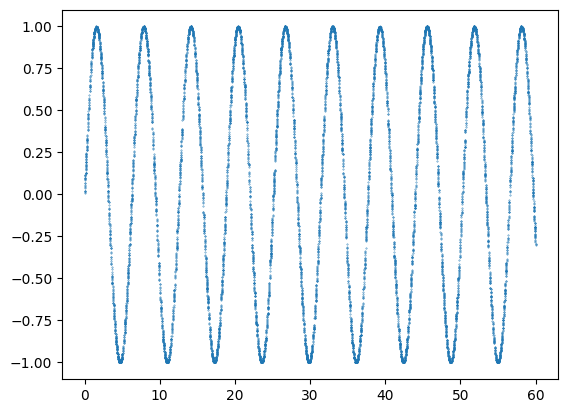

Epoch [1/100], Training Loss: 0.9992, Validation Loss: 0.7580
Epoch [2/100], Training Loss: 0.3068, Validation Loss: 0.6891
Epoch [3/100], Training Loss: 0.5627, Validation Loss: 0.6257
Epoch [4/100], Training Loss: 0.5833, Validation Loss: 0.5450
Epoch [5/100], Training Loss: 0.6795, Validation Loss: 0.4757
Epoch [6/100], Training Loss: 0.2267, Validation Loss: 0.3894
Epoch [7/100], Training Loss: 0.4256, Validation Loss: 0.3285
Epoch [8/100], Training Loss: 0.4698, Validation Loss: 0.2607
Epoch [9/100], Training Loss: 0.2593, Validation Loss: 0.2010
Epoch [10/100], Training Loss: 0.1070, Validation Loss: 0.1477
Epoch [11/100], Training Loss: 0.0087, Validation Loss: 0.1061
Epoch [12/100], Training Loss: 0.0783, Validation Loss: 0.0760
Epoch [13/100], Training Loss: 0.0575, Validation Loss: 0.0506
Epoch [14/100], Training Loss: 0.0209, Validation Loss: 0.0322
Epoch [15/100], Training Loss: 0.0149, Validation Loss: 0.0193
Epoch [16/100], Training Loss: 0.0104, Validation Loss: 0.0110
E

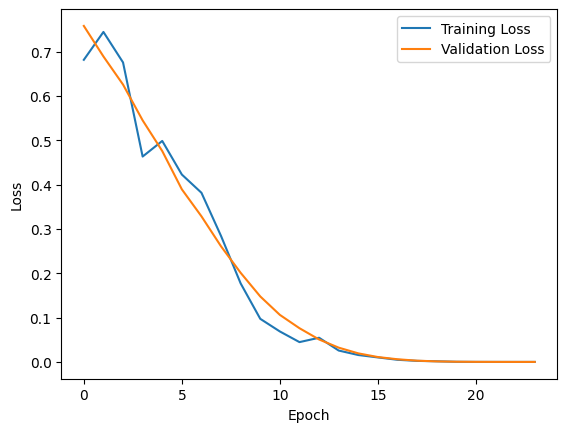

In [22]:
def anon():
    sine_data_10 = SineData(1, 0, n=10_000, dist_max=60).data()
    train_sine_data, test_sine_data, val_sine_data = split_dataset(sine_data_10)
    experiments['MLP-Tanh-DenseData'] = {
        'model': StupidSineApproximator().to(device),
        'dataset': sine_data_10,
        'train_data': train_sine_data,
        'test_data': test_sine_data,
        'val_data': val_sine_data,
        'learning_rate': 0.001,
        'max_epochs': 100,
    }
    plot_data(sine_data_10)

    exp = experiments['MLP-Tanh-DenseData']

    train_model(
        exp['model'],
        to_data_loader(exp['train_data']),
        to_data_loader(exp['val_data']),
        learning_rate=exp['learning_rate'],
        max_epochs=exp['max_epochs']
    )
anon()

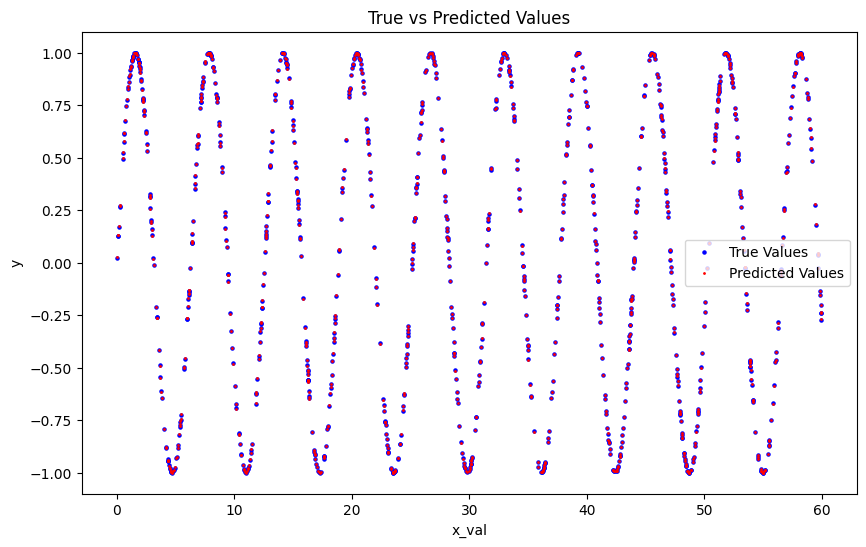

In [27]:
def print_predictions(x_val_list, y_val_list, y_predict_list):
    # Concatenate the lists of tensors into single tensors
    x_val = torch.cat(x_val_list, dim=0)
    y_val = torch.cat(y_val_list, dim=0)
    y_predict = torch.cat(y_predict_list, dim=0)

    # Convert tensors to NumPy arrays
    x_val_np = x_val.cpu().numpy()
    y_val_np = y_val.cpu().numpy()
    y_predict_np = y_predict.cpu().numpy()

    # Plot the true vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(x_val_np, y_val_np, s=5, color='blue', label='True Values')
    plt.scatter(x_val_np, y_predict_np, s=1, color='red', label='Predicted Values')
    plt.xlabel('x_val')
    plt.ylabel('y')
    plt.legend()
    plt.title('True vs Predicted Values')
    plt.show()

def anon():
    exp = experiments['MLP-Tanh-DenseData']
    model = exp['model']
    test_loader = to_data_loader(exp['test_data'])

    xs, ys, predictions = [], [], []

    for batch in test_loader:
        x_val, y_val = batch[:, 0].unsqueeze(1), batch[:, 1].unsqueeze(1)
        xs.append(x_val)
        ys.append(y_val)

        model.eval()
        with torch.no_grad():
            y_predict = model(x_val.to(device))
            predictions.append(y_predict)

    print_predictions(xs, ys, predictions)
anon()

Well there you go! Just goes to show that it can make sense to be smart about your activation function, especially if you know up front that your data it tightly cyclical. Next, I'll have a go at the passenger prophet dataset with a smartly-designed network and see what happens